##  Situation of covid 19 in Mexico


Between January and May, a total of 10,041 patients were registered in all country, of whom 24,905 were positive in SARS-CoV-2,and a total of 1,032 required respirators. 

#### Data loading and wrangling

In [123]:
#Importar librerias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import datetime
import json
import folium

In [124]:
#Cargar datos
dfm = pd.read_csv("CoordMunicipios.csv", encoding = "ISO-8859-1")
dfe = pd.read_csv("CoordEstados.csv", encoding = "ISO-8859-1")
df = pd.read_csv("200504COVID19MEXICO.csv", encoding = "ISO-8859-1")


In [38]:
#Reemplace por  Nans y 0,1:
cols=["SEXO","RESULTADO","EPOC","NEUMONIA","INTUBADO","DIABETES","ASMA","INMUSUPR","HIPERTENSION",'OTRA_COM','CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO',
       'OTRO_CASO']
df[cols]=df[cols].replace([3,97,98,99],np.nan)
df[cols]=df[cols].replace(2,0)



In [39]:
#Creo columns MUERTES: Muertes 0,1(1=Muerte)
lista_def=[]
for i in df["FECHA_DEF"]:
    if i=="9999-99-99":
        lista_def.append(0)
    else:
        lista_def.append(1)
df["MUERTES"]=lista_def

In [40]:
#Creo columna ENF: Con enferm!=0, Sin enferm=0
cols_enf=df[['EPOC','NEUMONIA','DIABETES','ASMA','INMUSUPR','HIPERTENSION',
   'OTRA_COM','CARDIOVASCULAR','OBESIDAD','RENAL_CRONICA','TABAQUISMO']]
df['ENF'] = cols_enf.sum(axis=1)


In [41]:
#Cambio a date time cols fechas
df["FECHA_DEF"]= df["FECHA_DEF"].replace("9999-99-99",np.nan)
from datetime import datetime
cols_fechas=['FECHA_INGRESO', 'FECHA_SINTOMAS',"FECHA_DEF"]
df[cols_fechas]=df[cols_fechas].apply(pd.to_datetime, format="%d/%m/%Y")

In [42]:
#Creo columns tiempo en UCI
df["TIEMPO_UCI"]=df["FECHA_DEF"]- df["FECHA_INGRESO"]

In [43]:
#Unir dataframes
df= df.rename(columns={"MUNICIPIO_RES":"Clave Municipio","ENTIDAD_RES":"Clave Estado"})
df= pd.merge(left=df, right=dfm, on =["Clave Municipio","Clave Estado"])

In [44]:
#Numero total de pacientes:
print("TOTAL PATIENTS: ",df.shape[0])
print("POSITIVES: ",df[df["RESULTADO"]==1].shape[0])
print("NEGATIVES: ",df[df["RESULTADO"]==0].shape[0])
print("PATIENTS IN UCI: ",df[(df["UCI"]==1)&(df["RESULTADO"]==1)].shape[0])
print("RESPIRATOR REQUIRED: ",df[(df["RESULTADO"]==1)&(df["INTUBADO"]==1)].shape[0])
print("FIRST DATE OF ENTRY: ", df["FECHA_INGRESO"].min())
print("LAST DAY OF ENTRY: ", df["FECHA_INGRESO"].max())
print("POSITIVE TOTAL_DEATHS: ",df[(df["RESULTADO"]==1)&(df["MUERTES"]==1)].shape[0])

TOTAL PATIENTS:  100040
POSITIVES:  24905
NEGATIVES:  61992
PATIENTS IN UCI:  1015
RESPIRATOR REQUIRED:  1032
FIRST DATE OF ENTRY:  2020-01-01 00:00:00
LAST DAY OF ENTRY:  2020-05-04 00:00:00
POSITIVE TOTAL_DEATHS:  2270


### THE RISK FACTORS FOR ASSISTED BREATHING

In [85]:
#Lista con num de intubados por factor de riesgo:
df_int=df[(df["RESULTADO"]==1)&(df["INTUBADO"]==1)]
lista_count=[]
lista_enf=['EPOC','NEUMONIA','DIABETES','ASMA','INMUSUPR','HIPERTENSION',
   'OTRA_COM','CARDIOVASCULAR','OBESIDAD','RENAL_CRONICA','TABAQUISMO']
for i in lista_enf:
    lista_count.append(df_int[df_int[i]==1][i].sum())

In [101]:
df3=df[(df["ENF"]!=0)&(df["UCI"]==1)&(df["MUERTES"]==1)]
df3[df3['OBESIDAD']==1]["TIEMPO_UCI"].max()
lista_enf2=['EPOC','NEUMONIA','DIABETES','ASMA','INMUSUPR','HIPERTENSION',
   'OTRA_COM','CARDIOVASCULAR','OBESIDAD','RENAL_CRONICA','TABAQUISMO']
lista_count2=[2539.0,18534.0,13481.0,4480.0,2402.0,17459.0,4802.0,3089.0,16314.0,2380.0,9671.0]
maximo=[]
media=[]
muertes=[]
for i in lista_enf2:
    day_max=(df3[df3[i]==1]["TIEMPO_UCI"].max()).days
    day_media=(df3[df3[i]==1]["TIEMPO_UCI"].mean()).days
    muer=df[(df["MUERTES"]==1)&(df["ENF"]!=0)][i].sum()
    maximo.append(day_max)
    muertes.append(muer)
    media.append(day_media)

lista_count2.append(df[(df["ENF"]==0)&df["INTUBADO"]==1]["INTUBADO"].sum())
maximo.append(df[df["ENF"]==0]["TIEMPO_UCI"].max().days) 
media.append(df[df["ENF"]==0]["TIEMPO_UCI"].mean().days)
muertes.append(df[(df["MUERTES"]==1)&(df["ENF"]==0)].shape[0])
lista_enf2.append("SIN FACTOR DE RIESGO")
df_uci=pd.DataFrame(columns=["TOTAL INTUBED PATIENTS","TOTAL DEATHS","MAXIMUN DAYS IN UCI(DEATHS)","AVERAGE DAYS IN UCI(DEATHS)"],
                   index=lista_enf2)
df_uci["MAXIMUN DAYS IN UCI(DEATHS)"]=maximo
df_uci["AVERAGE DAYS IN UCI(DEATHS)"]=media
df_uci["TOTAL INTUBED PATIENTS"]=lista_count2
df_uci["TOTAL DEATHS"]=muertes

In [102]:
df[(df["MUERTES"]==1)&(df["ENF"]==0)].shape[0]

224

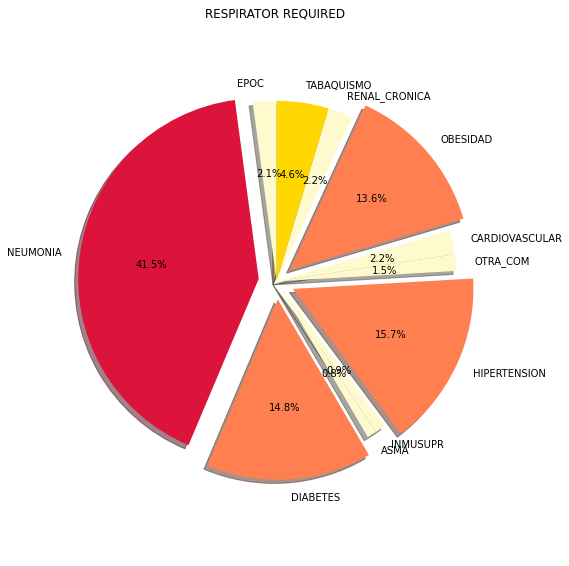

In [103]:
# Grafica por sectores 
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(aspect="equal"))

labels = lista_enf
sizes = lista_count

explode = (0, 0.1, 0.1, 0, 0, 0.1, 0, 0, 0.1, 0, 0)
colores=["#FFFACD", "#DC143C", "#FF7F50", "#FFFACD", "#FFFACD", "#FF7F50", "#FFFACD", "#FFFACD", "#FF7F50", "#FFFACD", "#FFD700"]

ax.pie(sizes, explode=explode, labels=labels,colors=colores, autopct='%1.1f%%',shadow=True, startangle=90)

ax.axis('equal')
plt.title("RESPIRATOR REQUIRED")
plt.tight_layout()
plt.show()

The presence of previous illnesses, are decisive in the need for a respirator, pneumonia is the greatest risk factor for need a respirator, diabetes, hippertension and obesity are the others greatest big risk factors .

In [104]:
df_uci
df_uci.sort_values(by=['TOTAL INTUBED PATIENTS'],ascending=False)

TOTAL INTUBED PATIENTS  TOTAL DEATHS  \
NEUMONIA                             18534.0        2584.0   
HIPERTENSION                         17459.0        1540.0   
OBESIDAD                             16314.0         943.0   
DIABETES                             13481.0        1440.0   
TABAQUISMO                            9671.0         371.0   
OTRA_COM                              4802.0         294.0   
ASMA                                  4480.0         100.0   
CARDIOVASCULAR                        3089.0         310.0   
EPOC                                  2539.0         322.0   
INMUSUPR                              2402.0         207.0   
RENAL_CRONICA                         2380.0         335.0   
SIN FACTOR DE RIESGO                    53.0         224.0   

                      MAXIMUN DAYS IN UCI(DEATHS)  AVERAGE DAYS IN UCI(DEATHS)  
NEUMONIA                                       43                            5  
HIPERTENSION                                   43                            6  
OBESIDAD                                       43                            6  
DIABETES                                       43                            5  
TABAQUISMO                                     29                            6  
OTRA_COM                                       22                            5  
ASMA                                           22                            5  
CARDIOVASCULAR                                 31                            5  
EPOC                                           31                            6  
INMUSUPR                                       31                            6  
RENAL_CRONICA                                  31                            5  
SIN FACTOR DE RIESGO                           32                            5

In [111]:
df[(df["NEUMONIA"]==0)&(df["DIABETES"]==1)&(df["MUERTES"]==1)].shape

(389, 43)

In [115]:
df[(df["NEUMONIA"]==0)&(df["INTUBADO"]==1)].shape

(157, 43)

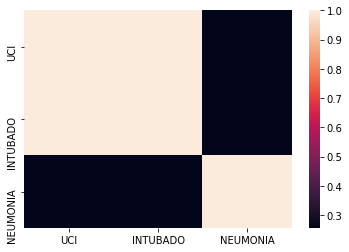

In [140]:
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(df[["UCI","INTUBADO","NEUMONIA"]].corr())


Hypertension, pneumonia and diabetes are the previous risk factors that represent a higher mortality rate.
However, there are no significant differences in the average time in the ICU.

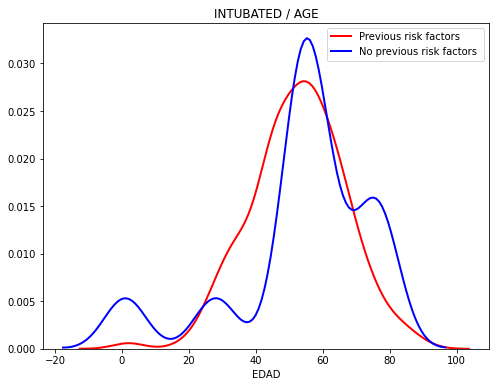

In [97]:
#Distribución de las edades que han dado positivo entre hombres y mujeres
df_pos=df[df["RESULTADO"]==1]
plt.subplots(figsize=(8,6))
sns.distplot(df_pos[(df_pos["ENF"]==1)&(df_pos["INTUBADO"]==1)]["EDAD"], kde_kws={"color": "r", "lw": 2, "label": "Previous risk factors"},hist=False)
sns.distplot(df_pos[(df_pos["ENF"]==0)&(df_pos["INTUBADO"]==1)]["EDAD"], kde_kws={"color": "b", "lw": 2, "label": "No previous risk factors "},hist=False)
plt.title("INTUBATED / AGE")
plt.show()

The following frequency graph shows that people who need a respirator and who don't have any previous risk factor are over 50 years old.
However, with the aforementioned risk factors, the age ratio is higher.

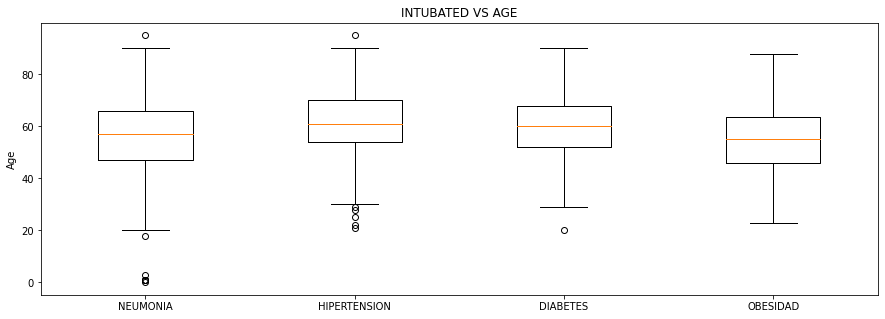

In [72]:
dfpi=df[(df["RESULTADO"]==1)&(df["INTUBADO"]==1)]
NEUMONIA= dfpi[dfpi["NEUMONIA"]==1]["EDAD"]
HIPERTENSION= dfpi[dfpi["HIPERTENSION"]==1]["EDAD"]
DIABETES= dfpi[dfpi["DIABETES"]==1]["EDAD"]
OBESIDAD= dfpi[dfpi["OBESIDAD"]==1]["EDAD"]



all_data=[NEUMONIA,HIPERTENSION,DIABETES,OBESIDAD]
labels=["NEUMONIA","HIPERTENSION","DIABETES","OBESIDAD"]

fig, ax = plt.subplots(figsize=(15,5))

ax.boxplot(all_data, labels=labels)
plt.ylabel("Age")
plt.title("INTUBATED VS AGE")
plt.show()
            

75% of intubated patients with obesity are in an age range between 45 and 65 years approximately.

In pneumonia patients the middle age range is similar, and there are a few cases in infants.

The average age in intubated people with hypertension, the average age is slightly higher

### Deaths Evolution

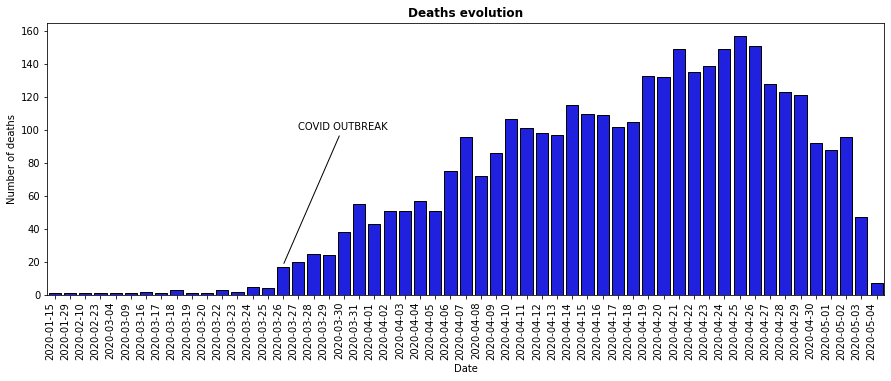

In [99]:
df_def=df[df["MUERTES"]==1]
fig, ax = plt.subplots(figsize=(15,5))
sns.countplot(df_def['FECHA_DEF'], color = "blue",edgecolor="black")
plt.title('Deaths evolution',weight = "bold")
plt.xlabel('Date')
plt.ylabel('Number of deaths')
plt.annotate(xy =(15,18),xytext = (16,100), s = "COVID OUTBREAK", arrowprops = dict(arrowstyle ="-"))
x_dates = df_def["FECHA_DEF"].dt.strftime('%Y-%m-%d').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
plt.savefig("Deaths evolution.jpg")
plt.xticks(rotation=90)
plt.show()

In [100]:
#Municipio con max de MUERTES por estado:
df_pos=df[(df["MUERTES"]==1)&(df["RESULTADO"]==1)]
df_pos=df_pos.groupby(["Estado","Municipio"],as_index=False).count().iloc[:,0:3]
Estados=df_pos["Estado"].unique()
lista_mun=[]
lista_values=[]
for i in lista_unicos:
    lista_mun.append(df_pos[df_pos["Estado"]==i].max()[1])
    lista_values.append(df_pos[df_pos["Estado"]==i].max()[2])
df_max=pd.DataFrame(columns=["MUNICIPIO","TOTAL DEATHS"],index=Estados)
#df_max["Estado"]=lista_unicos
df_max["MUNICIPIO"]=lista_mun
df_max["TOTAL DEATHS"]=lista_values
df_max

MUNICIPIO  TOTAL DEATHS
Aguascalientes                           Aguascalientes             9
Baja California                                 Tijuana           185
Baja California Sur                           Los Cabos            13
Campeche                                         Carmen            12
Chiapas                                Tuxtla Gutiérrez             2
Chihuahua                                       Rosales            75
Ciudad De México                         Álvaro Obregón            94
Coahuila De Zaragoza                            Torreón            26
Colima                                       Manzanillo             4
Durango                                      Tlahualilo             4
Estado De México                               Zumpango            33
Guanajuato                         Silao De La Victoria             6
Guerrero                                Xochihuehuetlán            13
Hidalgo                              Zapotlán De Juárez            13
Jalisco                                Zapotlán Del Rey             9
Michoacán De Ocampo                      Álvaro Obregón            23
Morelos                                       Zacatepec            15
Nayarit                                          Tuxpan             4
Nuevo León                       San Pedro Garza García             8
Oaxaca                              Zimatlán De Álvarez             5
Puebla                                           Zautla            52
Querétaro                                     Querétaro            11
Quintana Roo                                      Tulum            84
San Luis Potosí                          Villa De Ramos             6
Sinaloa                                         Sinaloa           124
Sonora                                            Sáric             4
Tabasco                                           Teapa            89
Tamaulipas                                  Xicoténcatl             8
Tlaxcala                                  Yauhquemehcan             2
Veracruz De Ignacio De La Llave                Veracruz            17
Yucatán                                         Yaxcabá            15
Zacatecas                                     Zacatecas             5

In [101]:
#Carga y preprocesado mapa
df2=df[df["MUERTES"]==1]
df2=df2.groupby(["Estado"],as_index=False).count().iloc[:,0:2]
df2=df2.rename(columns={"FECHA_ACTUALIZACION":"POSITIVOS"})

df2= pd.merge(left=df2, right=dfe, on =["Estado"])

In [102]:
json_estados=['Baja California','Baja California Sur','Coahuila De Zaragoza','Chihuahua','Durango','Sinaloa','Sonora',
             'Zacatecas','Nuevo Leon','San Luis Potosi','Tamaulipas','Aguascalientes','Colima','Jalisco','Michoacan De Ocampo',
             'Nayarit','Campeche','Oaxaca','Puebla','Tabasco','Tlaxcala','CDMX','Guanajuato','Guerrero','Hidalgo','Estado De Mexico',
             'Morelos','Queretaro','Veracruz De Ignacio De La Llave','Chiapas','Quintana Roo','Yucatan']
json_estados.sort()

#Reajuste de nombres json
df2=df2.replace("Ciudad De México",'CDMX')
df2=df2.replace("Querétaro",'Queretaro')
df2=df2.replace("Estado De México","Estado De Mexico")
df2=df2.replace("Yucatán","Yucatan")
df2=df2.replace("Michoacán De Ocampo","Michoacan De Ocampo")
df2=df2.replace("San Luis Potosí","San Luis Potosi")
df2=df2.replace("Nuevo León","Nuevo Leon")

In [148]:
# crea un mapa mundial
mexico_geo= r'/Users/rociocuestapedraz/Desktop/proyecto covid/mexico.json'
latitude=23.634501
longitude=-102.552784
mexico_map = folium.Map(location=[latitude, longitude], zoom_start=5, tiles='Mapbox Bright')
#Generar un choropleth map
mexico_map = folium.Map(location=[latitude, longitude], zoom_start=5, tiles='Mapbox Bright')
mexico_map
mexico_map.choropleth(
    geo_data=mexico_geo,
    #threshold_scale=[0,100,200,300,500,1000,3000,7000],
    data=df2,
    columns=['Estado','POSITIVOS'],
    key_on='feature.properties.name',
     fill_color='Reds', 
     fill_opacity=0.7, 
     line_opacity=0.2,
     legend_name='DEATHS',
)

mexico_map

### TOTAL POSITIVES MAP

In [103]:
#CREO DATAFRAME CON LA INFO DE POPSUP Y COORDENADAS
df3=df[df["RESULTADO"]==1]
df3=df3.groupby(["Estado","Municipio"],as_index=False)["RESULTADO"].sum()
df3["Latitud"]=dfm["Latitud"]
df3["Longitud"]=dfm["Longitud"]
lista_map=[]
for i,j in zip(df3["Municipio"],df3["RESULTADO"]):
    lista_map.append([i,j])
df3["info_map"]=lista_map

In [104]:
latitude=23.634501
longitude=-102.552784
mexico_map = folium.Map(location=[latitude, longitude], zoom_start=5)

positivos = folium.map.FeatureGroup()
X=df3['Latitud']
Y=df3['Longitud']
for lat, lng, in zip(X, Y): #la columna Y y X son las coordenadas 
    positivos.add_child(
            folium.CircleMarker([lat, lng],
            radius=5, # difine el tamaño de los circulos
            color='red',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )
#mexico_map.add_child(positivos)

In [105]:
from folium import plugins

# Comenzamos de nuevo con una copia limpia del mapa de San Francisco
mexico_map = folium.Map(location = [latitude, longitude], zoom_start = 5)

# Creamos una instancia de un objeto de clúster (mark cluster object)
#de marca para los incidentes en el marco de datos

positivos = plugins.MarkerCluster().add_to(mexico_map)

#Recorre los 100 crímenes y agrega a cada uno al feature group de incidentes

for lat, lng, label, in zip(X,Y,df3["info_map"]):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(positivos)

# display map
mexico_map